In [13]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
newsgroups = fetch_20newsgroups(subset='all')
df = pd.DataFrame({
    'text': newsgroups.data,
    'target': newsgroups.target
})

print(f"Dataset shape: {df.shape}")
print(df.head(3))

Dataset shape: (18846, 2)
                                                text  target
0  From: Mamatha Devineni Ratnam <mr47+@andrew.cm...      10
1  From: mblawson@midway.ecn.uoknor.edu (Matthew ...       3
2  From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...      17


In [3]:
print("\nMissing values:")

print(df.isnull().sum())

print("\nClass distribution:")

print(df['target'].value_counts())

print("\nRaw text example:")

print(df['text'][0][:500]) 


Missing values:
text      0
target    0
dtype: int64

Class distribution:
target
10    999
15    997
8     996
9     994
11    991
7     990
13    990
5     988
14    987
2     985
12    984
3     982
6     975
1     973
4     963
17    940
16    910
0     799
18    775
19    628
Name: count, dtype: int64

Raw text example:
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killin


In [4]:
def clean_text(text):
    if isinstance(text, float):
        return ""
    
    text = text.lower()
    
    text = re.sub(r'http\S+', '', text)
    
    text = re.sub(r'\S+@\S+', '', text)
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    text = ' '.join(text.split())
    
    return text


In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    tokens = text.split()

    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

df['normalized_text'] = df['cleaned_text'].apply(normalize_text)

In [6]:
all_words = ' '.join(df['normalized_text']).split()
word_freq = Counter(all_words)

rare_words = set(word for word, count in word_freq.items() if count < 5)
df['processed_text'] = df['normalized_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in rare_words])
)

In [7]:
def validate_text(text):
    if len(text.strip()) == 0:
        return False
    # Check minimum word count
    if len(text.split()) < 3:
        return False
    return True

original_size = len(df)
df = df[df['processed_text'].apply(validate_text)]
print(f"\nRemoved {original_size - len(df)} invalid entries")


Removed 0 invalid entries


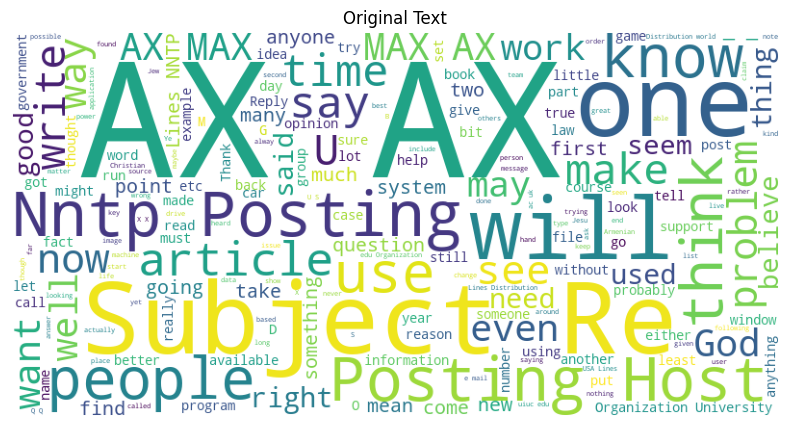

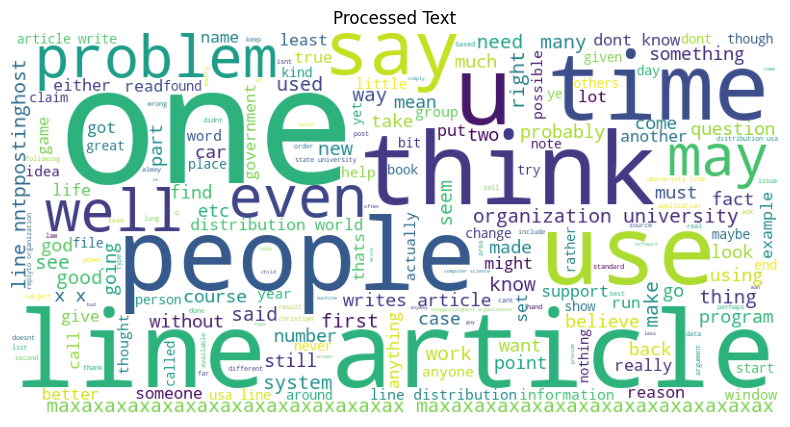

In [8]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=200
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.show()

plot_wordcloud(' '.join(df['text']), "Original Text")
plot_wordcloud(' '.join(df['processed_text']), "Processed Text")

In [9]:
df.to_csv('cleaned_text_data1.csv', index=False)

final_df = df[['processed_text', 'target']]
final_df.to_csv('ready_for_ml.csv', index=False)

print("\nFinal dataset shape:", final_df.shape)
print("Processing complete!")


Final dataset shape: (18846, 2)
Processing complete!


In [11]:
X = df['processed_text']
y = df['target']


Accuracy: 0.8645
Precision: 0.8653
Recall: 0.8645
F1-Score: 0.8637

Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.82      0.83      0.83       151
           comp.graphics       0.74      0.81      0.77       202
 comp.os.ms-windows.misc       0.78      0.79      0.79       195
comp.sys.ibm.pc.hardware       0.66      0.70      0.68       183
   comp.sys.mac.hardware       0.87      0.81      0.84       205
          comp.windows.x       0.82      0.80      0.81       215
            misc.forsale       0.82      0.77      0.79       193
               rec.autos       0.88      0.90      0.89       196
         rec.motorcycles       0.96      0.95      0.95       168
      rec.sport.baseball       0.96      0.94      0.95       211
        rec.sport.hockey       0.96      0.98      0.97       198
               sci.crypt       0.96      0.96      0.96       201
         sci.electronics       0.81      0.79    

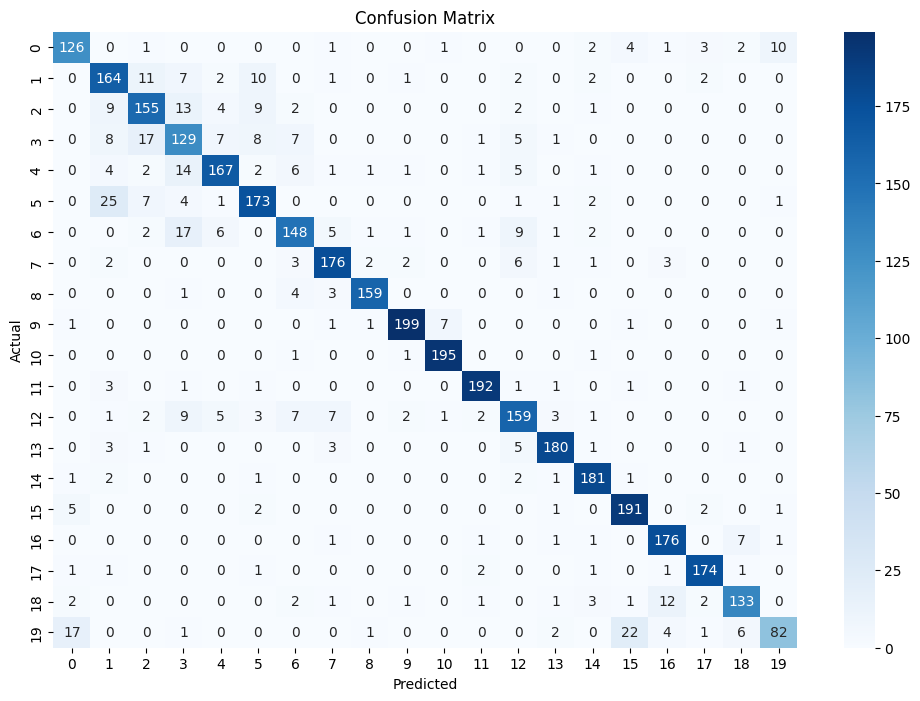

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=newsgroups.target_names))

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()